# Customer Lifetime Value Project – EDA Notebook 🧠📊

## Objective 📌

This notebook performs exploratory data analysis (EDA) on the customer purchase dataset, focusing on RFM (Recency, Frequency, Monetary, AveragePurchaseValue, CustomerLifespan, MeanDaysBetweenPurchases) features and deriving Customer Lifetime Value (CLV).

The goal is to understand customer purchasing behavior to support further modeling (e.g., churn prediction, segmentation, CLV regression).

---

## 1. Load RFM Data

In [1]:
import sys
import os
os.chdir("..")
# Добавляем src в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from importlib import reload
#import src.data_preparation.prepare_data as prepare_data
#reload(prepare_data)
from src.data_preparation import prepare_data
from src.feature_engineering import engineer_features

# Load and clean data
purchases, survey = prepare_data.load_raw_data()
df = prepare_data.clean_data(purchases)

# Create features (cutoff set to '2022-01-01' inside the function)
rfm_df = engineer_features.create_rfm_features(df,
                             customer_id_col='Survey ResponseID',
                             invoice_date_col='Order Date',
                             amount_col='TotalPrice')

rfm_df.head()

,Recency,Frequency,Monetary,AveragePurchaseValue,CustomerLifespan,MeanDaysBetweenPurchases
Survey ResponseID,,,,,,
R_01vNIayewjIIKMF,797,140,4920.01,35.142929,2081,14.864286
R_037XK72IZBJyF69,611,1213,17589.89,14.501146,2401,1.979390
R_038ZU6kfQ5f89fH,904,69,4247.54,61.558551,2067,29.956522
R_03aEbghUILs9NxD,544,173,3882.98,22.444971,2406,13.907514
R_06RZP9pS7kONINr,639,430,11223.70,26.101628,2396,5.572093


In [4]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5027 entries, R_01vNIayewjIIKMF to R_zfqnsBzlOAKibzb
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Recency                   5027 non-null   int64  
 1   Frequency                 5027 non-null   int64  
 2   Monetary                  5027 non-null   float64
 3   AveragePurchaseValue      5027 non-null   float64
 4   CustomerLifespan          5027 non-null   int64  
 5   MeanDaysBetweenPurchases  5027 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 274.9+ KB


## 2. Summary Statistics

In [5]:
rfm_df.describe()

,Recency,Frequency,Monetary,AveragePurchaseValue,CustomerLifespan,MeanDaysBetweenPurchases
count,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000
mean,618.701611,368.155361,8763.404241,26.201522,2247.062861,27.214318
std,146.768395,426.407538,9782.756813,12.404197,309.012763,64.522061
min,0.000000,1.000000,1.840000,1.840000,0.000000,0.000000
25%,534.000000,92.000000,2254.065000,19.053317,2238.000000,4.785410
50%,603.000000,232.000000,5706.990000,23.856875,2392.000000,9.744939
75%,637.000000,489.000000,11706.020000,29.994104,2412.000000,23.737895
max,2245.000000,5415.000000,115391.180000,194.203256,2418.000000,1169.500000


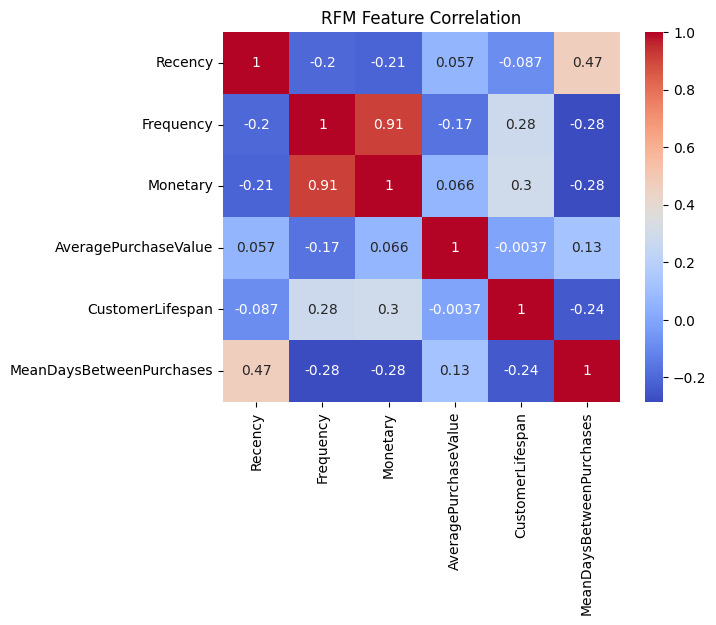

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(rfm_df.corr(), annot=True, cmap='coolwarm')
plt.title("RFM Feature Correlation")
plt.show()

## 3. Distributions

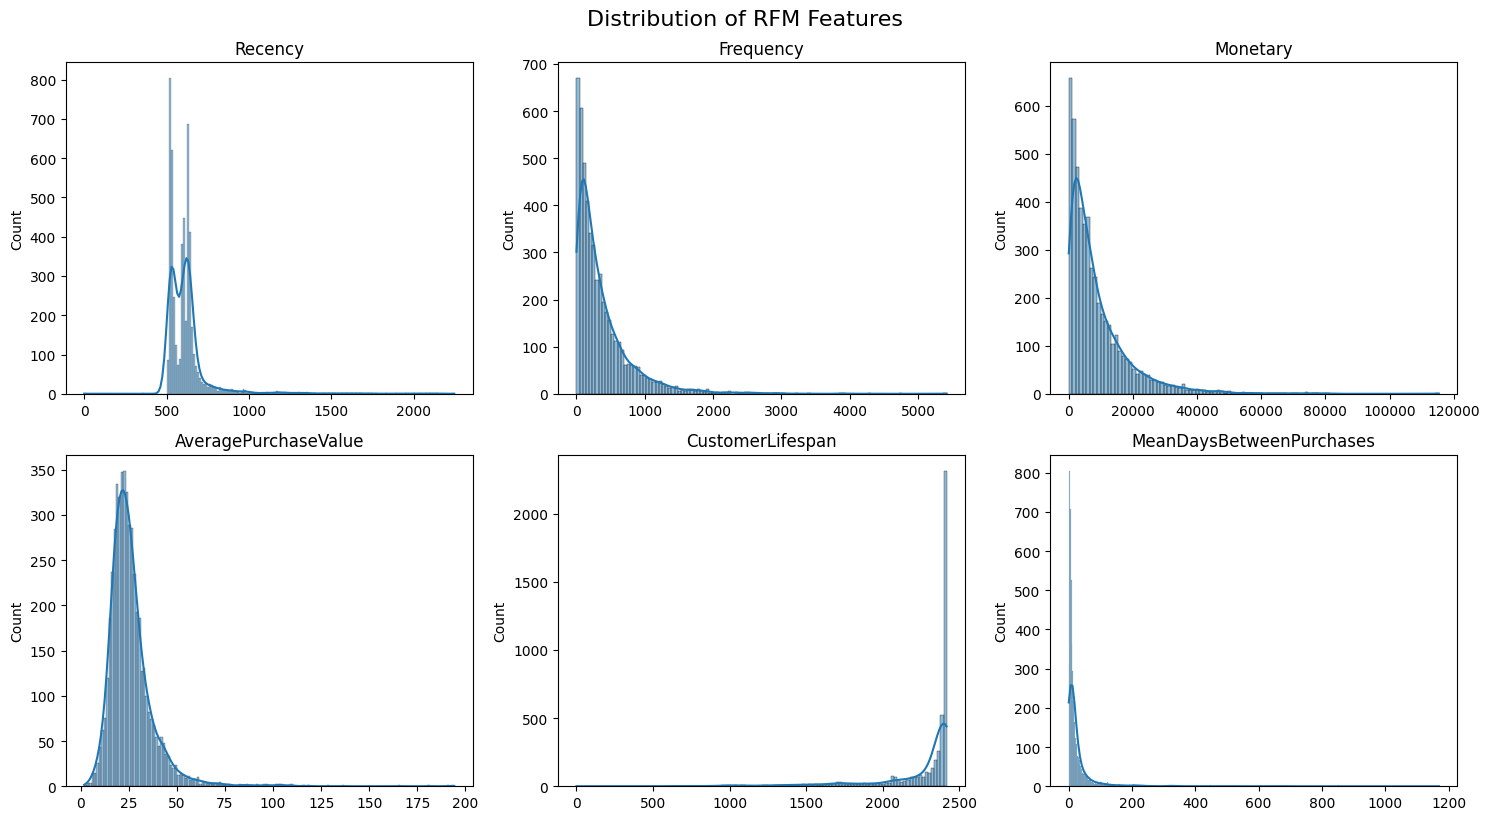

In [7]:
plt.figure(figsize=(15, 8))

for i, col in enumerate(rfm_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(rfm_df[col], kde=True)
    plt.title(col)
    plt.xlabel("")
    plt.tight_layout()

plt.suptitle("Distribution of RFM Features", fontsize=16, y=1.02)
plt.show()

## 4. Features outliers

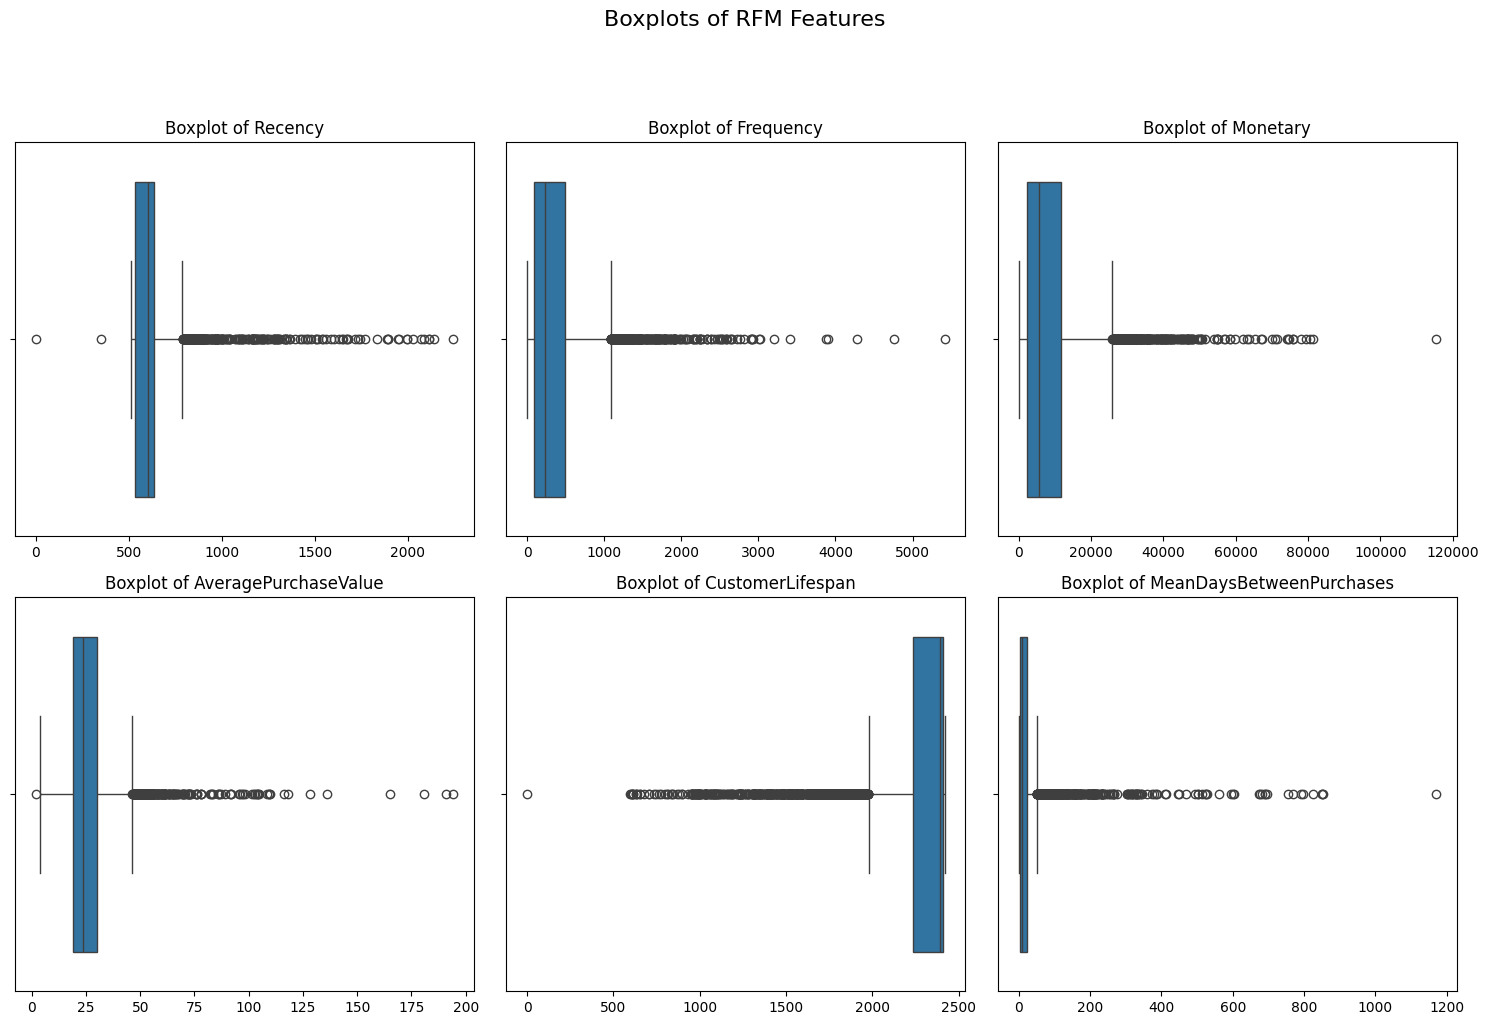

In [8]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(rfm_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=rfm_df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel("")

plt.suptitle("Boxplots of RFM Features", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

In [9]:
import numpy as np

for col in rfm_df.columns:
    q1 = rfm_df[col].quantile(0.25)
    q3 = rfm_df[col].quantile(0.75)
    iqr = q3 - q1
    outliers = rfm_df[(rfm_df[col] < (q1 - 1.5 * iqr)) | (rfm_df[col] > (q3 + 1.5 * iqr))]
    print(f'Outliers in {col}: {len(outliers)}')

Outliers in Recency: 270
Outliers in Frequency: 307
Outliers in Monetary: 297
Outliers in AveragePurchaseValue: 240
Outliers in CustomerLifespan: 666
Outliers in MeanDaysBetweenPurchases: 559


## 5. Feature Transformation

To address strong skewness and scale disparities among RFM features, we applied a mixed transformation strategy:

- **Logarithmic transformation** was applied to `Frequency`, `Monetary`, and `AveragePurchaseValue`, as they are strictly positive and heavily right-skewed.
- **Quantile transformation (normal output distribution)** was used for `Recency`, `CustomerLifespan`, and `MeanDaysBetweenPurchases`, which showed extreme skewness and high variance in scale. This method helps to approximate a normal distribution, making features more suitable for many machine learning models.

This combination balances interpretability and model-readiness.



In [10]:
from sklearn.preprocessing import QuantileTransformer
import numpy as np

# Копируем датафрейм
rfm_transformed = rfm_df.copy()

# 1. Log-transformation
log_cols = ['Frequency', 'Monetary', 'AveragePurchaseValue']
rfm_transformed[log_cols] = rfm_transformed[log_cols].apply(lambda x: np.log1p(x))

# 2. QuantileTransformer
skewed_cols = ['Recency', 'CustomerLifespan', 'MeanDaysBetweenPurchases']
qt = QuantileTransformer(output_distribution='normal', random_state=42)
rfm_transformed[skewed_cols] = qt.fit_transform(rfm_transformed[skewed_cols])


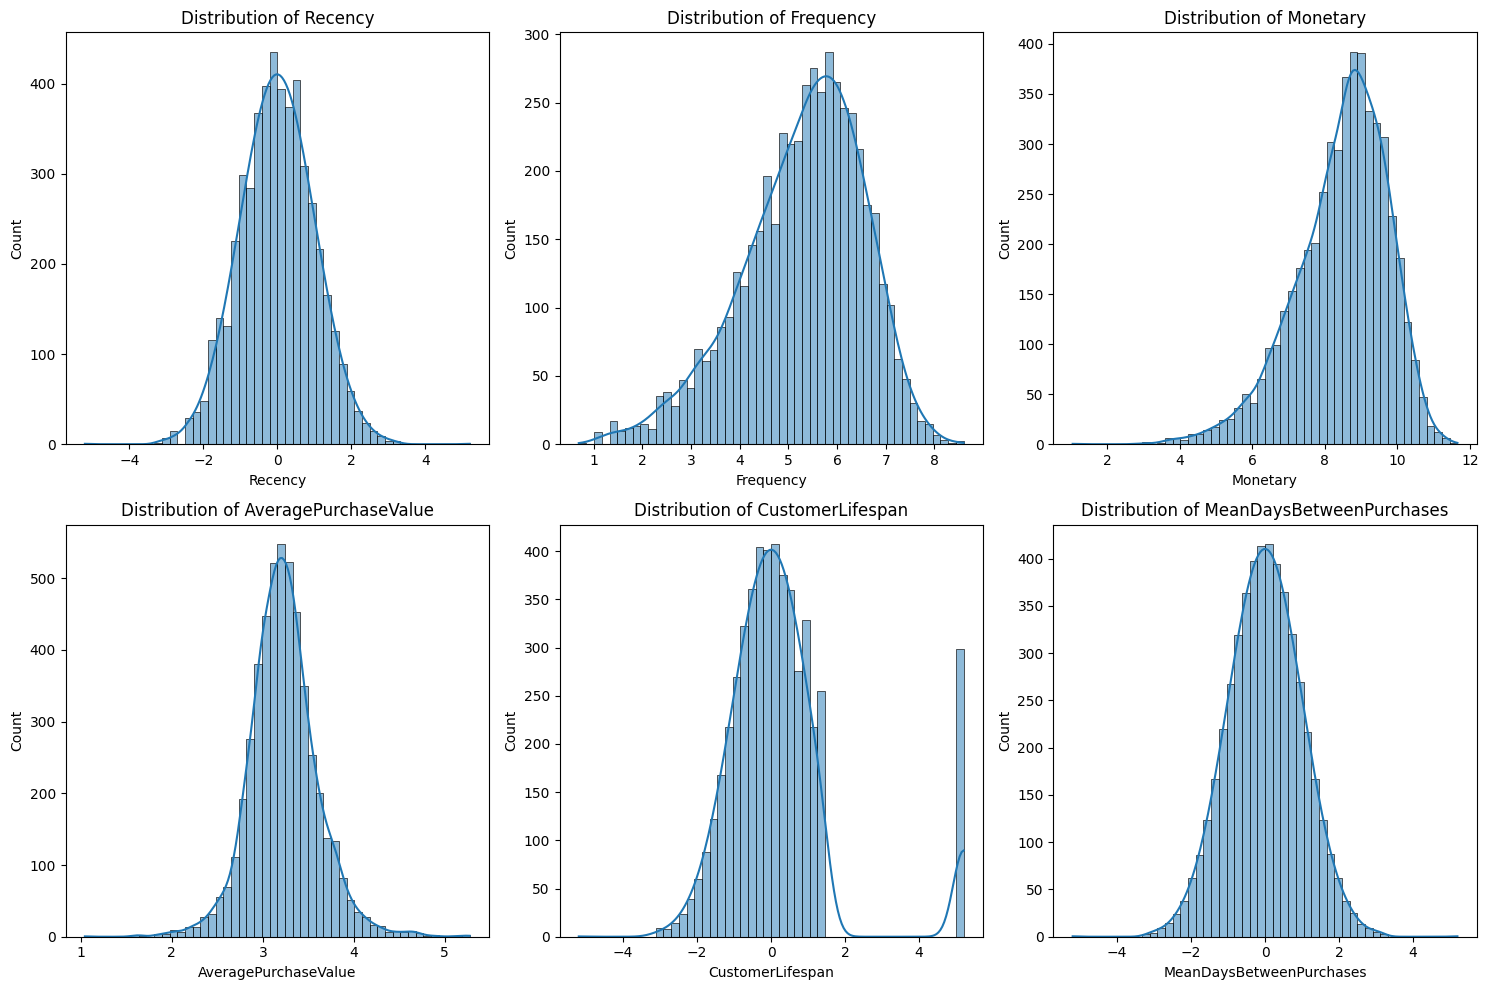

In [11]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(rfm_transformed.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(rfm_transformed[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Now we can check outliars

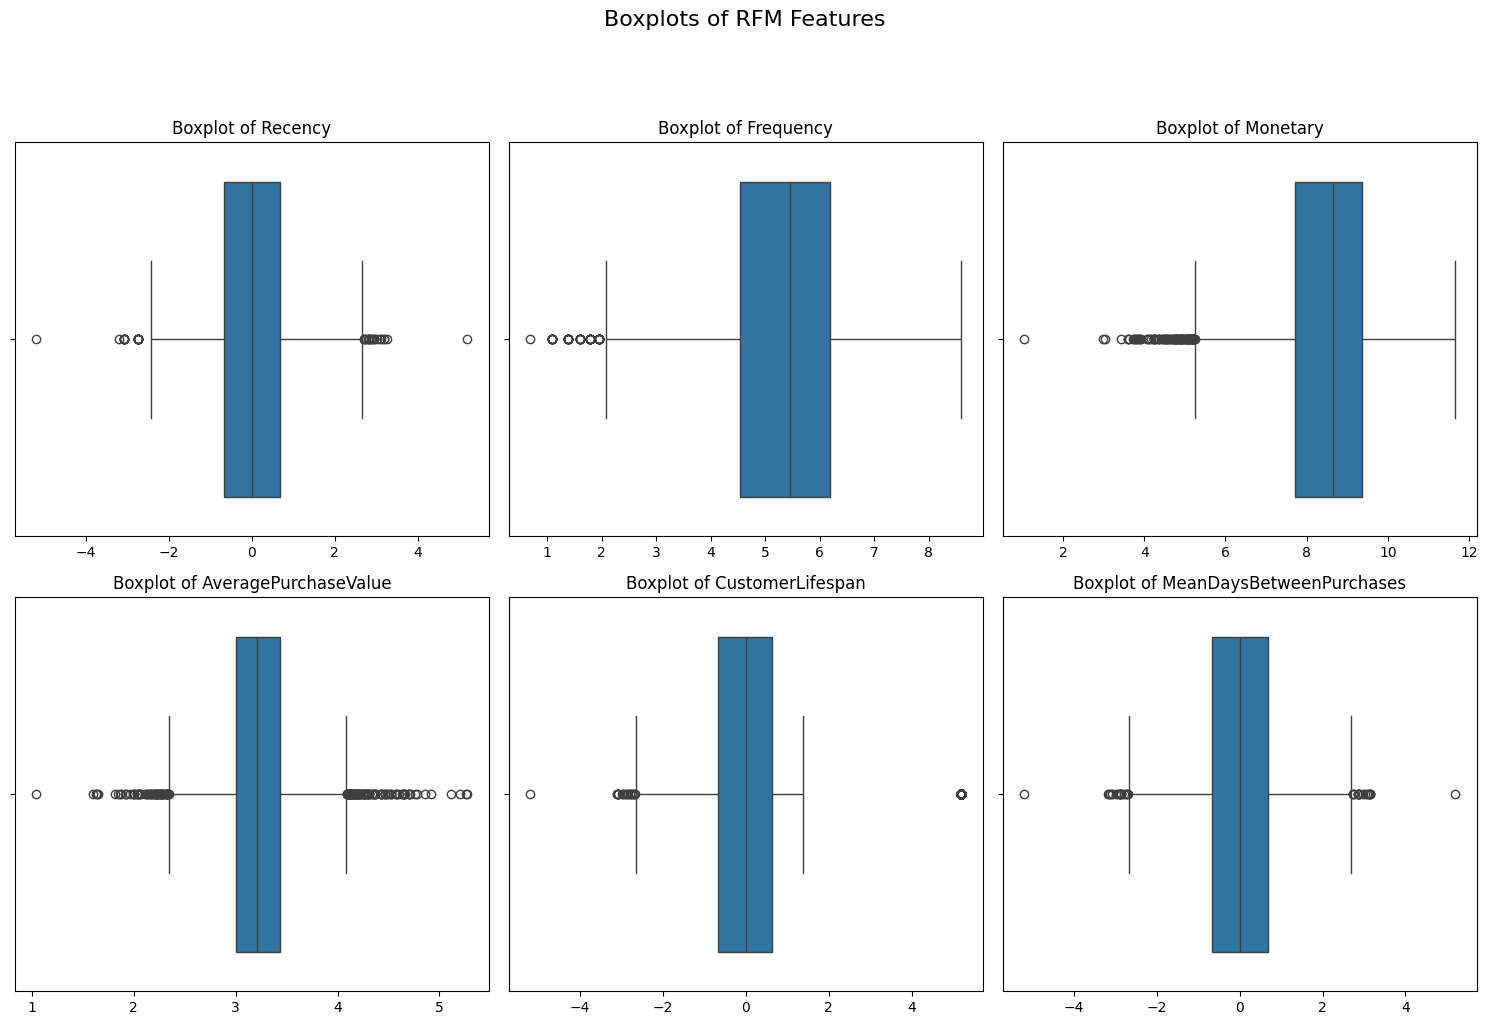

In [12]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(rfm_transformed.columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=rfm_transformed, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel("")

plt.suptitle("Boxplots of RFM Features", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

## 6. Target Variable Construction – Future Customer Lifetime Value (CLV)

To predict future customer lifetime value, we define our target variable as the total monetary value of purchases made by a customer after a selected cutoff date (`2022-01-01`).  
This allows us to simulate a real-world scenario where we predict future value based on historical behavior.

The steps are:
- Filter purchases that occurred after the cutoff date.
- Group by customer and calculate the total value.
- Merge this information with our feature matrix.


In [17]:
# Define cutoff
cutoff_date = pd.to_datetime("2022-01-01")

# Get purchases made after the cutoff
future_df = df[df["Order Date"] >= cutoff_date]

# Calculate total future spend (CLV) per customer
clv_target = future_df.groupby("Survey ResponseID")["TotalPrice"].sum().reset_index()
clv_target.columns = ["Survey ResponseID", "FutureCLV"]

# Merge with feature matrix
rfm_target_df = rfm_transformed.reset_index().merge(clv_target, on="Survey ResponseID", how="left")

# Fill customers with no future purchases with 0
rfm_target_df["FutureCLV"] = rfm_target_df["FutureCLV"].fillna(0)

# Display sample
rfm_target_df.head()

,Survey ResponseID,Recency,Frequency,Monetary,AveragePurchaseValue,CustomerLifespan,MeanDaysBetweenPurchases,FutureCLV
0,R_01vNIayewjIIKMF,1.628121,4.948760,8.501269,3.587481,-0.973449,0.336877,417.18
1,R_037XK72IZBJyF69,0.162552,7.101676,9.775136,2.740914,0.186756,-1.662790,3835.52
2,R_038ZU6kfQ5f89fH,1.840376,4.248495,8.354331,4.136103,-1.010382,0.842542,333.54
3,R_03aEbghUILs9NxD,-0.469603,5.159055,8.264616,3.154656,0.342823,0.283509,549.26
4,R_06RZP9pS7kONINr,0.736442,6.066108,9.325872,3.299594,0.071571,-0.519760,2968.76


## 7. Target Variable Analysis

To better understand the nature of our prediction target, we analyzed the distribution and correlation of **Customer Lifetime Value (CLV)** — defined as total customer spend after a selected cutoff date (`2022-01-01`). The raw CLV values were heavily skewed, so we applied a log(1 + x) transformation to improve normality and stabilize variance.

### Key Observations:
- The **log-transformed CLV** distribution is approximately normal with a single prominent mode.
- The strongest **correlations** with future CLV are:
  - `Monetary` (0.67)
  - `Frequency` (0.65)
  - `LogFutureCLV` (0.64)
  - `CustomerLifespan` (0.29)
- **Recency** and **MeanDaysBetweenPurchases** show moderate negative correlations, consistent with RFM theory (more recent/frequent buyers are more valuable).

This analysis confirms that historical RFM metrics can be good predictors of future customer value and justifies their inclusion as features in upcoming modeling steps.


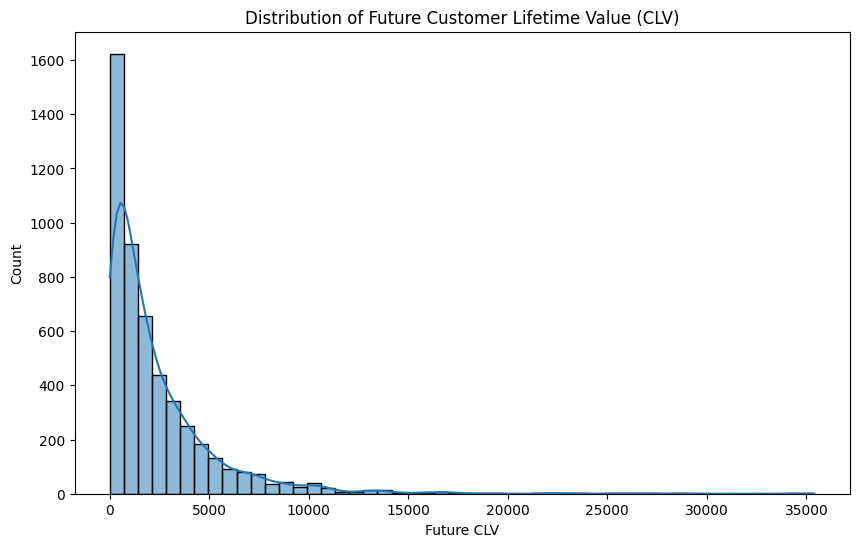

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm_target_df["FutureCLV"], bins=50, kde=True)
plt.title("Distribution of Future Customer Lifetime Value (CLV)")
plt.xlabel("Future CLV")
plt.ylabel("Count")
plt.show()

In [19]:
print("Target Summary Statistics:")
print(rfm_target_df["FutureCLV"].describe())

zero_clv_ratio = (rfm_target_df["FutureCLV"] == 0).mean()
print(f"\nPercentage of customers with zero future CLV: {zero_clv_ratio:.2%}")

Target Summary Statistics:
count     5027.000000
mean      2318.442158
std       2888.614764
min          0.000000
25%        493.480000
50%       1390.330000
75%       3096.680000
max      35398.780000
Name: FutureCLV, dtype: float64

Percentage of customers with zero future CLV: 2.82%


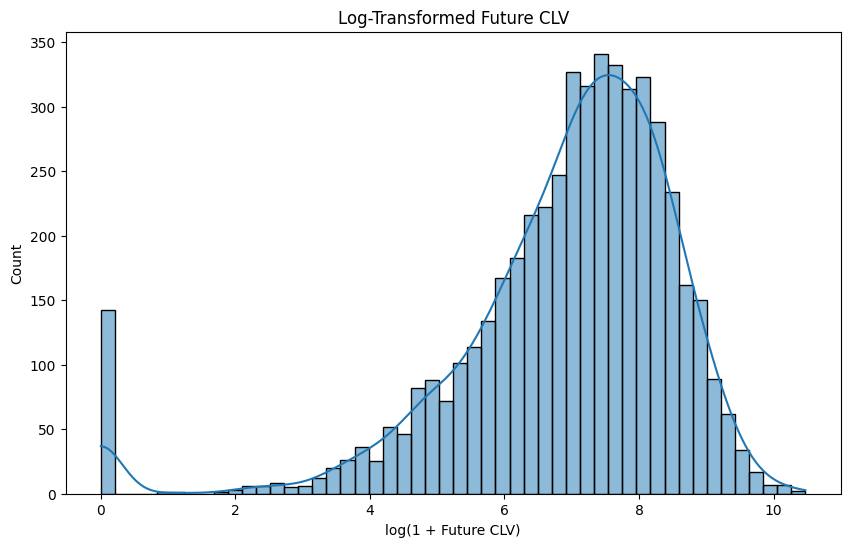

In [20]:
import numpy as np

# Добавим колонку с логарифмом (для моделей и визуализации)
rfm_target_df["LogFutureCLV"] = np.log1p(rfm_target_df["FutureCLV"])

plt.figure(figsize=(10, 6))
sns.histplot(rfm_target_df["LogFutureCLV"], bins=50, kde=True)
plt.title("Log-Transformed Future CLV")
plt.xlabel("log(1 + Future CLV)")
plt.ylabel("Count")
plt.show()

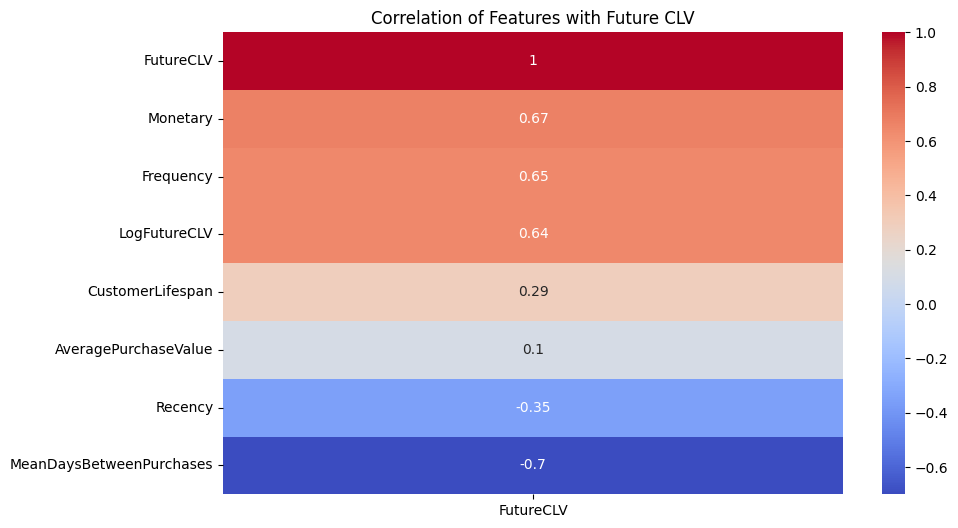

In [21]:
corr = rfm_target_df.drop(columns=["Survey ResponseID"]).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr[["FutureCLV"]].sort_values(by="FutureCLV", ascending=False), annot=True, cmap="coolwarm")
plt.title("Correlation of Features with Future CLV")
plt.show()

## 7. Uploading Datase

In [ ]:
rfm_target_df.to_csv("data/processed/rfm_target_df.csv")